**Fraud Detection System for Financial Transactions**






Week 1: Data Ingestion and Exploratory Data Analysis (EDA)

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score
import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import warnings


In [2]:


# Load the dataset
df = pd.read_csv('financial_fraud_detection.csv')

# Print the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# Print the shape of the data
print("\nShape of the dataset:")
print(df.shape)


Shape of the dataset:
(6362620, 11)


2 Basic Information:

In [4]:
# Check for missing values and data types
df.info()

# Summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
# --- Outlier Detection using IQR Method for 'amount' ---

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]

# Print the number of outliers and a sample
print(f"\n Number of outliers in 'amount': {len(outliers)}")
print("Sample of detected outliers:")
print(outliers[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud']].head())

# Optional: create a new column marking outliers
df['is_outlier_amount'] = ((df['amount'] < lower_bound) | (df['amount'] > upper_bound)).astype(int)



 Number of outliers in 'amount': 338078
Sample of detected outliers:
    step      amount  oldbalanceOrg  newbalanceOrig  isFraud
85     1  1505626.01            0.0             0.0        0
86     1   554026.99            0.0             0.0        0
88     1   761507.39            0.0             0.0        0
89     1  1429051.47            0.0             0.0        0
93     1   583848.46            0.0             0.0        0


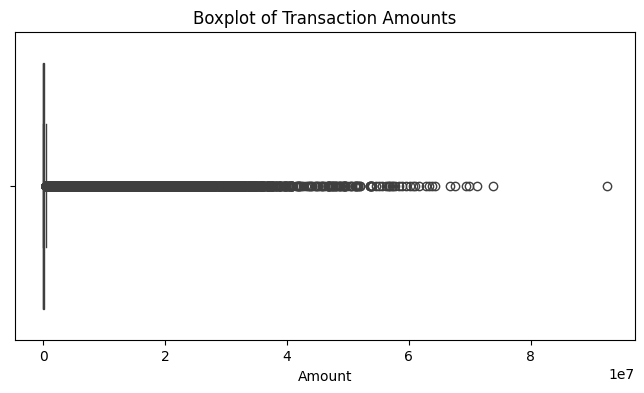

In [6]:
# Boxplot to visualize outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['amount'])
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("Amount")
plt.show()


In [7]:
# Check missing values
print("\nMissing values in each column:")
print(df.isna().sum())


Missing values in each column:
step                 0
type                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
is_outlier_amount    0
dtype: int64


In [8]:
# Print unique values counts for each column
for col in df.columns:
    print(f"\nUnique values for column '{col}':")
    print(df[col].value_counts())
    print("======================================================")


Unique values for column 'step':
step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64

Unique values for column 'type':
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Unique values for column 'amount':
amount
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: count, Length: 5316900, dtype: int64

Unique values for column 'nameOrig':
nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64

Unique values for column 'oldb

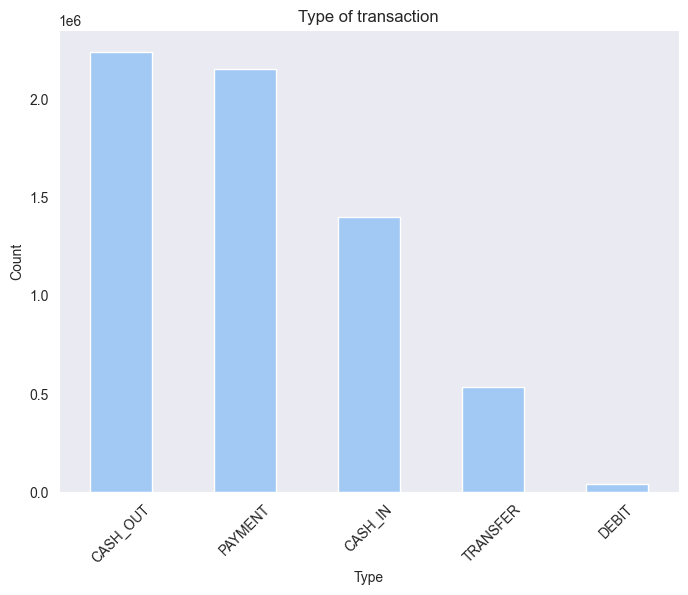

In [9]:
# Plot 1: Bar plot of transaction types
sns.set_style("dark")
sns.set_palette("pastel")
plt.figure(figsize=(8,6))
df['type'].value_counts().plot(kind='bar')
plt.title('Type of transaction')
plt.xticks(rotation=45)
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

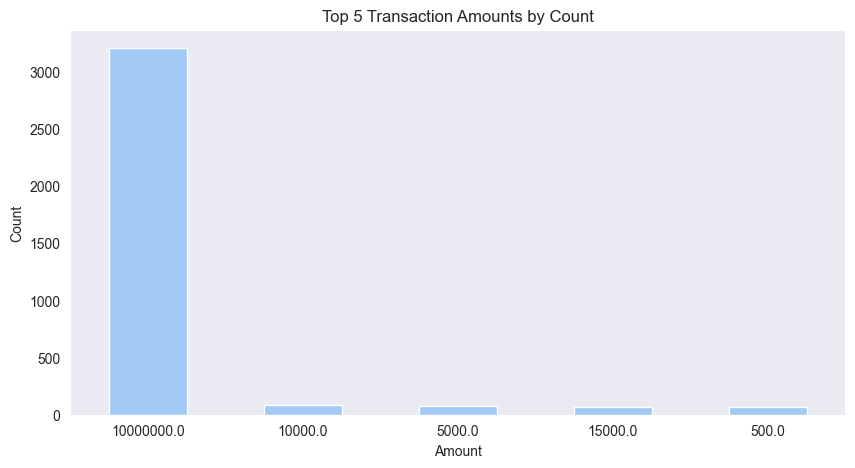

In [10]:

# Plot 2: Bar plot of top 5 transaction amounts by count
plt.figure(figsize=(10,5))
df['amount'].value_counts().sort_values(ascending=False).head().plot(kind='bar')
plt.title("Top 5 Transaction Amounts by Count")
plt.xticks(rotation=0)
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

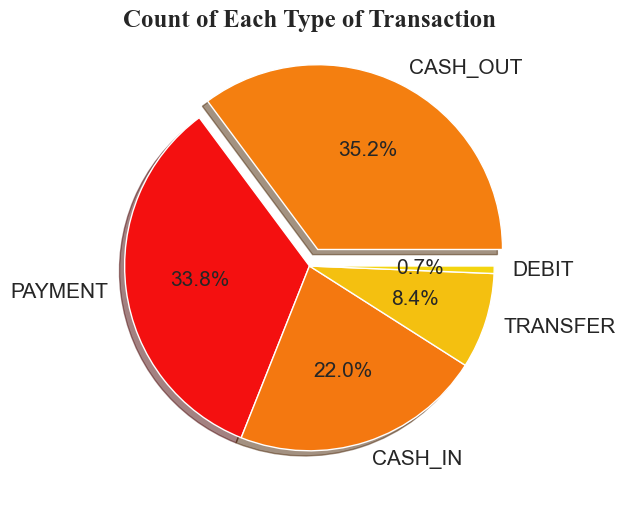

In [11]:
# Plot 3: Pie chart of count of each type of transaction
counts = df['type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%",
        colors=['#F47F10', '#F41010', '#F47810', '#F4C010', '#F4D510'],
        shadow=True, explode=(0.1, 0, 0, 0, 0), textprops={'fontsize': 15})
plt.title('Count of Each Type of Transaction', fontweight='bold', fontsize=18, fontfamily='times new roman')
plt.show()

In [12]:
# Group by 'type' and 'isFraud' and count
fraud_counts = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
print("\nCount of transactions by type and fraud status:")
print(fraud_counts)


Count of transactions by type and fraud status:
isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097


Week 2: Feature Engineering and Model Training

In [13]:
# ======= Feature Engineering =======

# 1. Encode categorical 'type' feature using LabelEncoder
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# 2. Drop original 'type' column if you want, or keep it for reference
df.drop('type', axis=1, inplace=True)


In [14]:
# 3. Define features and target
X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

In [16]:
# 4. Scale features - numeric columns (except 'type_encoded')
import warnings
warnings.filterwarnings('ignore')  # Optional: general suppression
scaler = StandardScaler()
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])



In [17]:
# 5. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


 Logistic Regression Cross-Validation Evaluation:
F1 Scores (CV): [0.56314199 0.57211538 0.59519625 0.57687723 0.55382775]
Average F1 Score: 0.5722317230609754


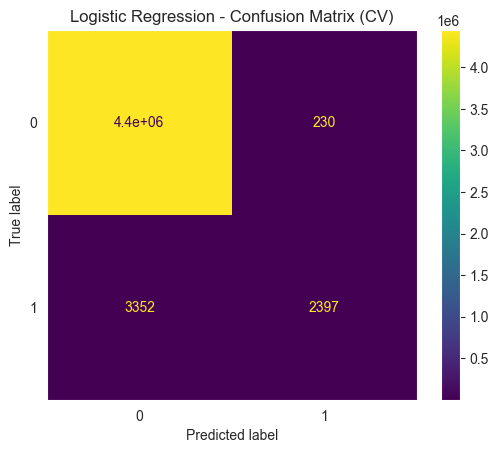

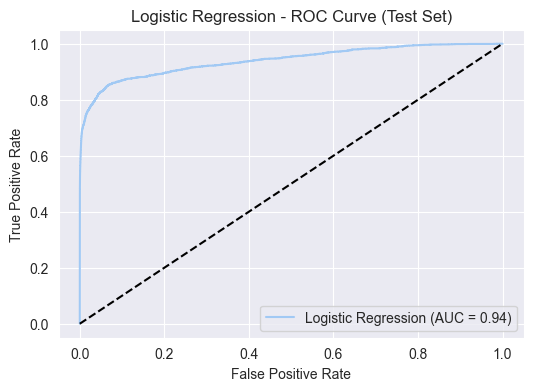

Test Set Evaluation:
F1 Score: 0.5535117056856187
Precision: 0.8834519572953736
ROC AUC: 0.9397631436023461
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.88      0.40      0.55      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.70      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786


 Decision Tree Cross-Validation Evaluation:
F1 Scores (CV): [0.87885561 0.87282463 0.8753826  0.87136564 0.87314086]
Average F1 Score: 0.8743138671002736


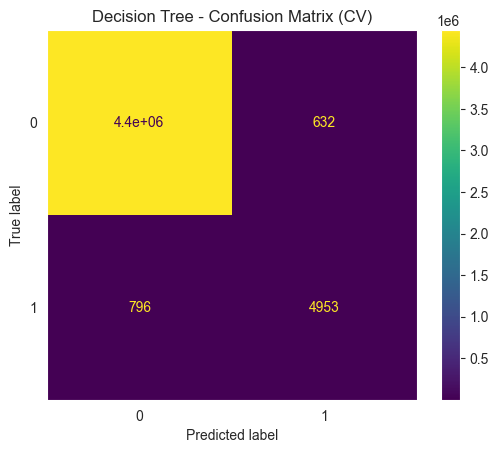

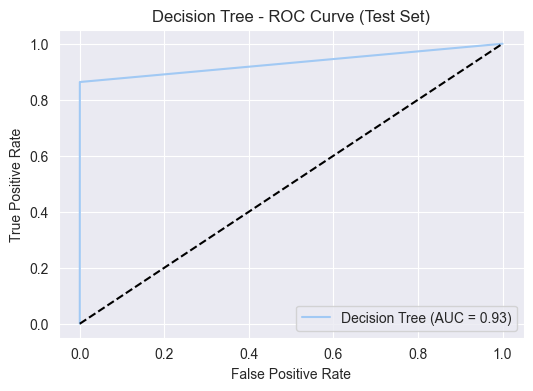

Test Set Evaluation:
F1 Score: 0.8697607851155184
Precision: 0.8763906056860321
ROC AUC: 0.9315365741876616
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.88      0.86      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.93      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786


 XGBoost Cross-Validation Evaluation:
F1 Scores (CV): [0.86899767 0.82510383 0.52488263 0.80428705 0.61142322]
Average F1 Score: 0.7269388789851522


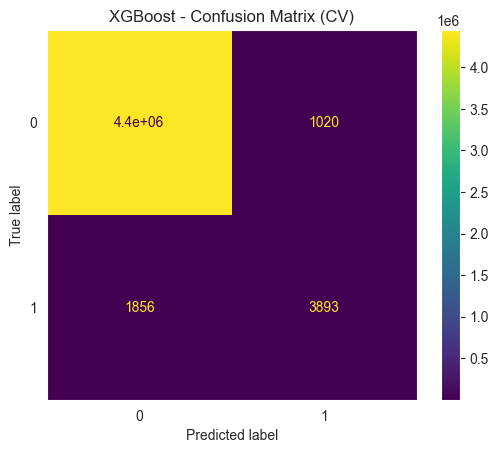

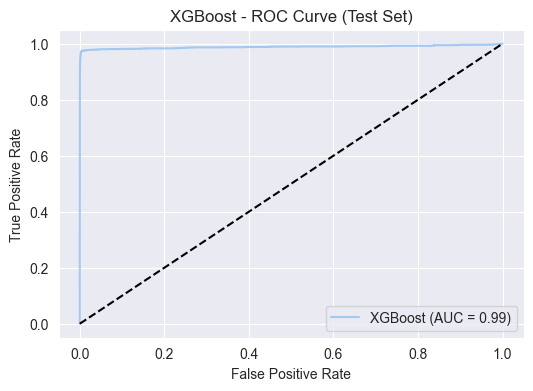

Test Set Evaluation:
F1 Score: 0.8696027633851469
Precision: 0.9289667896678967
ROC AUC: 0.9886302287818549
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.93      0.82      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.91      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



In [19]:


# Define cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n {name} Cross-Validation Evaluation:")

    # Get cross-validated F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
    print("F1 Scores (CV):", f1_scores)
    print("Average F1 Score:", f1_scores.mean())

    # Cross-validated predictions (for confusion matrix)
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=skf, method='predict')
    cm = confusion_matrix(y_train, y_pred_cv)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} - Confusion Matrix (CV)')
    plt.show()

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # ROC AUC (test set)
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve (Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Final metrics on test set
    print("Test Set Evaluation:")
    print("F1 Score:", f1_score(y_test, y_pred_test))
    print("Precision:", precision_score(y_test, y_pred_test))
    print("ROC AUC:", roc_auc)
    print(classification_report(y_test, y_pred_test))
    warnings.filterwarnings('ignore')

Week 3: Hyperparameter Tuning & Pipeline

In [ ]:
# model_training.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score, precision_score, roc_auc_score
import joblib
import warnings

# Load data
df = pd.read_csv('financial_fraud_detection.csv')

# Encode 'type' column
df['type_encoded'] = LabelEncoder().fit_transform(df['type'])
df.drop('type', axis=1, inplace=True)

# Define X and y
X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Columns to scale
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = StandardScaler()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)
    ],
    remainder='passthrough'  # keeps 'type_encoded'
)

# Define models and their param grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1.0, 10.0]
    },
    'Decision Tree': {
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.01, 0.1]
    }
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train, evaluate, and select best model
best_model = None
best_score = 0
best_model_name = ""

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid = GridSearchCV(pipe, param_grids[name], cv=skf, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    score = f1_score(y_test, y_pred)

    print(f"\n{name} Evaluation:")
    print("Best Params:", grid.best_params_)
    print("F1 Score:", score)
    print("Precision:", precision_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_
        best_model_name = name

# Save the best model and scaler
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(f"\n Best model saved: {best_model_name} with F1 score: {best_score:.4f}")

warnings.filterwarnings('ignore')



Logistic Regression Evaluation:
Best Params: {'model__C': 10.0}
F1 Score: 0.5690968443960827
Precision: 0.863036303630363
ROC AUC: 0.7122129541673892
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.86      0.42      0.57      2464

    accuracy                           1.00   1908786
   macro avg       0.93      0.71      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786


Decision Tree Evaluation:
Best Params: {'model__max_depth': 20, 'model__min_samples_split': 2}
F1 Score: 0.8693230505569837
Precision: 0.9205989110707804
ROC AUC: 0.9116829961982138
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.82      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.91      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



C:\Users\GEETANJALI\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Evaluation:
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
F1 Score: 0.8636869023793641
Precision: 0.9552385636989671
ROC AUC: 0.8940508073737206
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.79      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786


 Best model saved: Decision Tree with F1 score: 0.8693
